In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import sys
import os
sys.path.append(os.path.join(os.environ['NHL_DATA_DIR'], '..'))

In [16]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier


import src.visualization.visualize as VizManager
import src.data.NHLDataManager as DataManager
import src.features.build_features as FeaturesManager



RANDOM_SEED = 42

In [60]:
# Get the dataset
seasons_year = [2015, 2016, 2017, 2018, 2019]
season_type = "Regular"
features_data_df = FeaturesManager.build_features(seasons_year, season_type, with_player_stats=True, with_strength_stats=True)
features_data_df.columns

/home/fidaa/anaconda3/envs/NHL/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/fidaa/anaconda3/envs/NHL/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/fidaa/anaconda3/envs/NHL/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/fidaa/anaconda3/envs/NHL/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Index(['Game ID', 'Event Index', 'Period', 'Team', 'Type', 'Shot Type',
       'Shooter', 'Shooter ID', 'Goalie', 'Goalie ID', 'Strength', 'X', 'Y',
       'Last event type', 'Last event X', 'Last event Y',
       'Last event elapsed time', 'Last event distance', 'st_X', 'st_Y',
       'Last event st_X', 'Last event st_Y', 'Shot distance', 'Shot angle',
       'Is Goal', 'Is Empty', 'Period seconds', 'Game seconds',
       'Last event angle', 'Rebound', 'Change in Shot Angle',
       'Speed From Previous Event', 'Shooter Goal Ratio Last Season',
       'Goalie Goal Ratio Last Season', 'Num players With',
       'Num players Against', 'Elapsed time since Power Play'],
      dtype='object')

In [65]:
# features_data_df.query("`Game ID` == '2018020002'")[['Game ID', 'Event Index', 'Strength',  'Num players With', 'Num players Against']].head(50)
data_manager = DataManager.NHLDataManager()

df_goals = features_data_df.query(f"`Game ID` == '2018020002' & Type == 'Goal'")
df_shots = features_data_df.query(f"`Game ID` == '2018020002' & Type == 'Shot'")
df_penalties = data_manager.get_penalties_df(2018, "Regular", 2)

goals_shots_penalities_ordered_df = _get_goals_shots_penalities_ordered(df_goals, df_shots, df_penalties)


,Game ID,Event Index,Strength,Num players With,Num players Against
228111,2018020002,5,Even,5.0,5.0
228112,2018020002,6,Even,5.0,5.0
228113,2018020002,10,Even,5.0,5.0
228114,2018020002,14,Power Play,5.0,4.0
228115,2018020002,18,Short Handed,4.0,5.0
228116,2018020002,33,Even,5.0,5.0
228117,2018020002,38,Even,5.0,5.0
228118,2018020002,41,Even,5.0,5.0
228119,2018020002,52,Even,5.0,5.0
228120,2018020002,57,Even,5.0,5.0


In [66]:
# features_data_df.info()

col1 = 'Shooter Goal Ratio Last Season'
col2 = 'Goalie Goal Ratio Last Season'
features_data_df[[col1, col2]] = features_data_df[[col1, col2]].fillna(features_data_df[[col1, col2]].median())

print(features_data_df.shape)
print(features_data_df.dropna().shape)

features_data_df.dropna(inplace=True)

features_data_df[['Game ID', 'Event Index', 'Team', 'Strength', 'Num players With', 'Num players Against']].head(50)

(371905, 37)
(371760, 37)


,Game ID,Event Index,Team,Strength,Num players With,Num players Against
0,2015020001,7,Toronto Maple Leafs (TOR),Even,5.0,5.0
1,2015020001,9,Toronto Maple Leafs (TOR),Even,5.0,5.0
2,2015020001,10,Toronto Maple Leafs (TOR),Even,5.0,5.0
3,2015020001,13,Toronto Maple Leafs (TOR),Even,5.0,5.0
4,2015020001,21,Toronto Maple Leafs (TOR),Even,5.0,5.0
5,2015020001,24,Montréal Canadiens (MTL),Even,5.0,5.0
6,2015020001,29,Montréal Canadiens (MTL),Even,5.0,5.0
7,2015020001,45,Montréal Canadiens (MTL),Even,5.0,5.0
8,2015020001,46,Montréal Canadiens (MTL),Even,5.0,5.0
9,2015020001,54,Toronto Maple Leafs (TOR),Even,5.0,5.0


In [9]:
test_df = features_data_df.query(f"`Game ID` == '2018021260'").copy()
test_df['Num players With'] = 5
test_df['Num players Against'] = 5
test_df['Strength'] = 'Even'
test_df['Elapsed time since Power Play'] = 0     

features_data_df[features_data_df.isnull().any(axis=1)].shape
test_df = features_data_df.drop(['Shooter Goal Ratio Last Season', 'Goalie Goal Ratio Last Season'], axis=1)
nan_values = test_df[test_df.isnull().any(axis=1)]
nan_values[['Game ID', 'Event Index', 'Type', 'X', 'Y', 'Last event X', 'Last event Y', 'Last event type', 'Last event angle']]
# test_df.query('`Event Index` == 271')

# data_manager = DataManager.NHLDataManager()
# df_goals = features_data_df.query(f"`Game ID` == '2018021260' & Type == 'GOAL'")
# df_shots = features_data_df.query(f"`Game ID` == '2018021260' & Type == 'SHOT'")
# df_penalties = data_manager.get_penalties_df(2018, "Regular", 1260)

# print(type(df_penalties))

# goals_shots_penalities_ordered_df = FeaturesManager._get_goals_shots_penalities_ordered(df_goals, df_shots, df_penalties)
# goals_shots_penalities_ordered_df = FeaturesManager._compute_strength_and_num_players(goals_shots_penalities_ordered_df)

# goals_shots_penalities_ordered_df

,Game ID,Event Index,Type,X,Y,Last event X,Last event Y,Last event type,Last event angle


In [7]:
# Just a sanity check
data_manager = DataManager.NHLDataManager()
player_stats = data_manager.load_player(8473618, 2015)
shots = player_stats['stats'][0]['splits'][0]['stat']['shots']
goals = player_stats['stats'][0]['splits'][0]['stat']['goals']
ratio = goals / shots
np.any([np.math.isclose(ratio, v) for v in features_data_df.query('`Shooter ID` == 8473618')['Shooter Goal Ratio Last Season'].unique()])

True

In [8]:
names = ['Period', 'Period seconds', 'Shot Type', 'Shot distance', 'Shot angle', 'Is Empty',
         'Rebound', 'Speed From Previous Event', 'Change in Shot Angle', 
         'Shooter Goal Ratio Last Season', 'Goalie Goal Ratio Last Season', 
         'Strength', 'Num players With', 'Num players Against', 'Elapsed time since Power Play',
         'Last event elapsed time', 'Last event distance', 'Last event angle', 
         'Is Goal']

feature_names, target_name = names[0:-2], names[-1]
feature_names = np.array(feature_names)

df_filter = features_data_df[names]
# print(df_filter.shape)

# # Be careful with dropna. For example, if we choose the 'Strenght' feature, if will remove all the shots
# df_filter = df_filter.dropna()

# # Check if we have any nan values left
df_filter.isnull().values.any()

False

In [9]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305730 entries, 0 to 305859
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Period                          305730 non-null  int64  
 1   Period seconds                  305730 non-null  float64
 2   Shot Type                       305730 non-null  object 
 3   Shot distance                   305730 non-null  float64
 4   Shot angle                      305730 non-null  float64
 5   Is Empty                        305730 non-null  float64
 6   Rebound                         305730 non-null  float64
 7   Speed From Previous Event       305730 non-null  float64
 8   Change in Shot Angle            305730 non-null  float64
 9   Shooter Goal Ratio Last Season  305730 non-null  float64
 10  Goalie Goal Ratio Last Season   305730 non-null  float64
 11  Strength                        305730 non-null  object 
 12  Num players With

In [10]:
dummy_shot_type = pd.get_dummies(df_filter['Shot Type'], prefix='Shot Type')
df_filter = df_filter.merge(dummy_shot_type, left_index=True, right_index=True)
df_filter = df_filter.drop(columns=['Shot Type'])

dummy_strength = pd.get_dummies(df_filter['Strength'], prefix='Strength')
df_filter = df_filter.merge(dummy_strength, left_index=True, right_index=True)
df_filter = df_filter.drop(columns=['Strength'])

# Update features_name
feature_names = list(df_filter.columns)
feature_names = [f for f in feature_names if f != 'Is Goal']
feature_names = np.array(feature_names)

In [11]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305730 entries, 0 to 305859
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Period                          305730 non-null  int64  
 1   Period seconds                  305730 non-null  float64
 2   Shot distance                   305730 non-null  float64
 3   Shot angle                      305730 non-null  float64
 4   Is Empty                        305730 non-null  float64
 5   Rebound                         305730 non-null  float64
 6   Speed From Previous Event       305730 non-null  float64
 7   Change in Shot Angle            305730 non-null  float64
 8   Shooter Goal Ratio Last Season  305730 non-null  float64
 9   Goalie Goal Ratio Last Season   305730 non-null  float64
 10  Num players With                305730 non-null  float64
 11  Num players Against             305730 non-null  float64
 12  Elapsed time sin

In [13]:
X = df_filter[feature_names]
y = df_filter[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

num_goals = (y == 1).sum()
num_shots = (y == 0).sum()
print(y.shape)
print(num_goals / num_shots)

num_goals = (y_train == 1).sum()
num_shots = (y_train == 0).sum()
print(y_train.shape)
print(num_goals / num_shots)


(305730,)
0.1032763044411806
(244584,)
0.10327530910419552


In [22]:
clf_forest = RandomForestClassifier(random_state=RANDOM_SEED)

scaler = MinMaxScaler()
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('s', scaler), ('o', over), ('u', under), ('m', clf_forest)]

pipeline_forest = Pipeline(steps=steps)

# evaluate pipeline
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline_forest, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)
# print(scores)

pipeline_forest.fit(X_train, y_train)

y_pred = pipeline_forest.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     55422
         1.0       0.59      0.13      0.21      5724

    accuracy                           0.91     61146
   macro avg       0.75      0.56      0.58     61146
weighted avg       0.89      0.91      0.88     61146



In [26]:
clf_adaboost = AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)

scaler = MinMaxScaler()
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('s', scaler), ('o', over), ('u', under), ('m', clf_adaboost)]

pipeline_adaboost = Pipeline(steps=steps)

# evaluate pipeline
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline_forest, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)
# print(scores)

pipeline_adaboost.fit(X_train, y_train)

y_pred = pipeline_adaboost.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91     55422
         1.0       0.28      0.44      0.34      5724

    accuracy                           0.84     61146
   macro avg       0.61      0.66      0.63     61146
weighted avg       0.88      0.84      0.86     61146



In [27]:
clf_gradientboost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=RANDOM_SEED)

scaler = MinMaxScaler()
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('s', scaler), ('o', over), ('u', under), ('m', clf_gradientboost)]

pipeline_gradient_boost = Pipeline(steps=steps)

# evaluate pipeline
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline_forest, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)
# print(scores)

pipeline_gradient_boost.fit(X_train, y_train)

y_pred = pipeline_gradient_boost.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91     55422
         1.0       0.28      0.44      0.34      5724

    accuracy                           0.84     61146
   macro avg       0.61      0.66      0.63     61146
weighted avg       0.88      0.84      0.86     61146



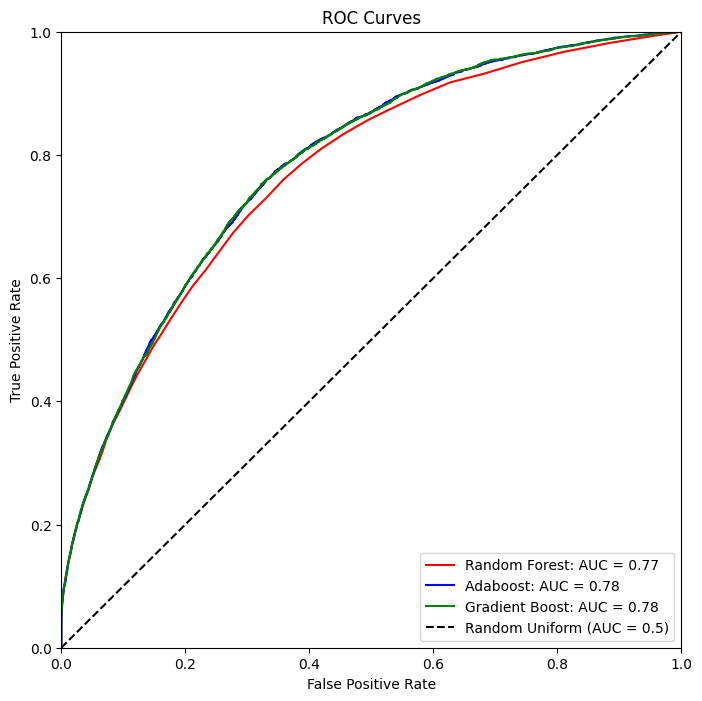

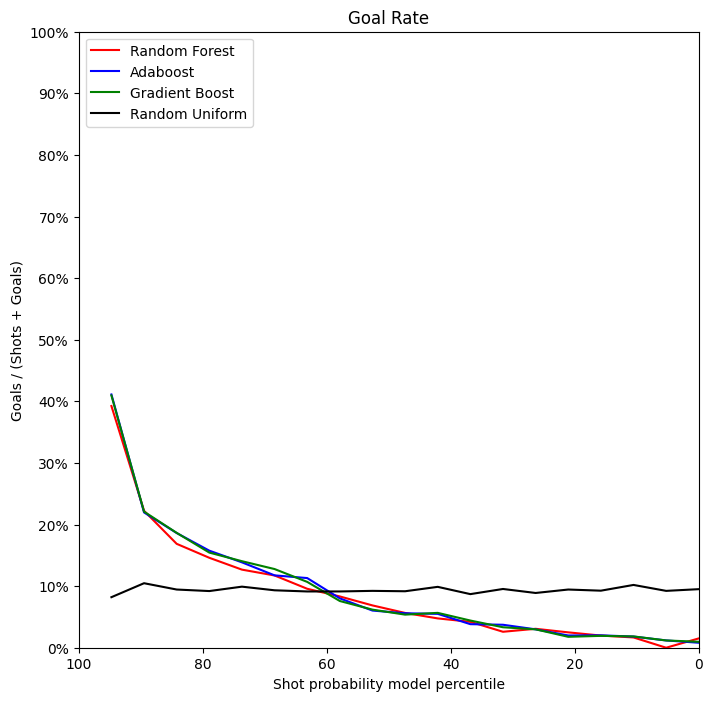

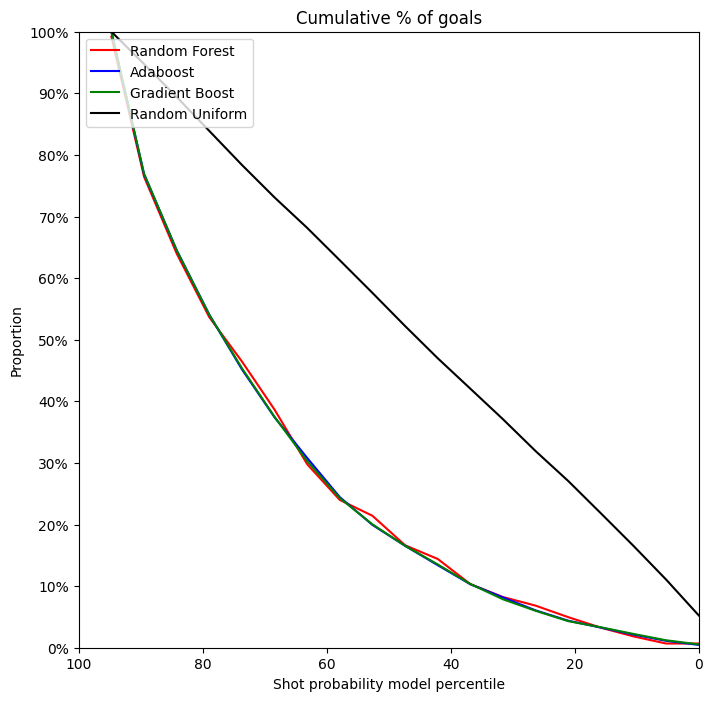

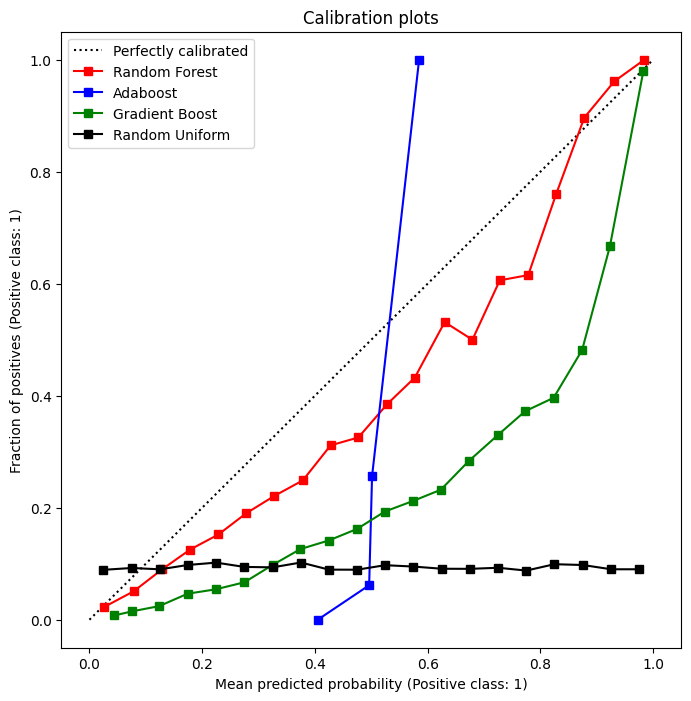

In [28]:
classifiers = [(pipeline_forest, 'Random Forest', X_valid, y_valid),
               (pipeline_adaboost, 'Adaboost', X_valid, y_valid),
               (pipeline_gradient_boost, 'Gradient Boost', X_valid, y_valid)]
VizManager.plot_all_figures(classifiers, add_random=True)